# Exp_12: Apply slef attention model in transformers on a small text and extract the attention vectors for each of the tokens in the text sequence. Compare how context is build with attention on a text sequence with necessary visualizations of attention mechanism.

# Self-Attention Demonstration and Attention Extraction
This notebook shows how self-attention builds contextualized token representations.

It includes:
1. A small handcrafted scaled-dot product self-attention implementation (pure NumPy).
2. Extraction and visualization of attention matrices for a short sentence.
3. Optional extraction of attention from a HuggingFace transformer (if `transformers` is available).

Sentence used: **"The quick brown fox jumps over the lazy dog"**


In [1]:
# 1) Setup: imports and helper functions
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.decomposition import PCA

np.random.seed(42)

# Tokenize simple whitespace (keeps it simple for demo)
sentence = 'The quick brown fox jumps over the lazy dog'
tokens = sentence.split()

# Helpers
def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

def plot_attention_matrix(attn, tokens, title='Attention'):
    plt.figure(figsize=(6,5))
    plt.title(title)
    plt.imshow(attn, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.xticks(np.arange(len(tokens)), tokens, rotation=45, ha='right')
    plt.yticks(np.arange(len(tokens)), tokens)
    plt.tight_layout()
    plt.show()

print('setup done; tokens:', tokens)


setup done; tokens: ['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


attn_weights shape: (9, 9)


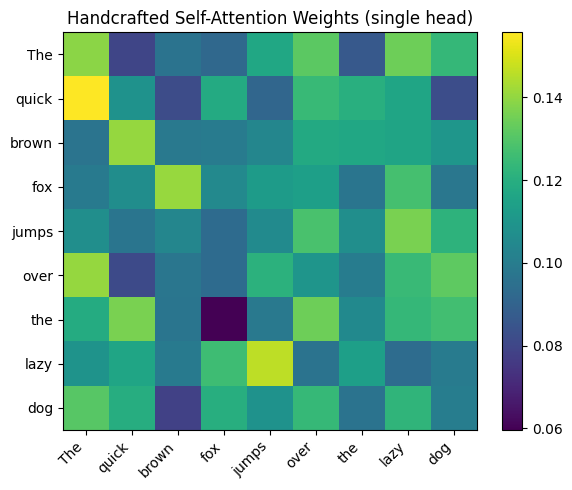

Token:    The | top-3 attended tokens indices: [0 7 5] | weights: [0.13905585 0.13455446 0.13156258]
Token:  quick | top-3 attended tokens indices: [0 5 6] | weights: [0.15573881 0.12453239 0.12024384]
Token:  brown | top-3 attended tokens indices: [1 5 6] | weights: [0.14041284 0.11815592 0.11688361]
Token:    fox | top-3 attended tokens indices: [2 7 5] | weights: [0.14091566 0.12724677 0.11381389]
Token:  jumps | top-3 attended tokens indices: [7 5 8] | weights: [0.13636054 0.1281272  0.12180313]
Token:   over | top-3 attended tokens indices: [0 8 7] | weights: [0.14048205 0.13187498 0.12480444]
Token:    the | top-3 attended tokens indices: [1 5 8] | weights: [0.13624647 0.13460169 0.12663304]
Token:   lazy | top-3 attended tokens indices: [4 3 1] | weights: [0.14617106 0.12607151 0.11605343]
Token:    dog | top-3 attended tokens indices: [0 5 7] | weights: [0.13062492 0.1241068  0.12254588]


In [2]:
# 2) Handcrafted scaled-dot product self-attention (single head)
# We'll create random token embeddings and compute Q,K,V via linear projections

d_model = 64  # embedding dim
n_tokens = len(tokens)

# Random token embeddings (simulated token vectors)
embeddings = np.random.randn(n_tokens, d_model) * 0.5

# Random projection matrices for Q,K,V
W_q = np.random.randn(d_model, d_model) * 0.1
W_k = np.random.randn(d_model, d_model) * 0.1
W_v = np.random.randn(d_model, d_model) * 0.1

Q = embeddings @ W_q  # shape (n_tokens, d_model)
K = embeddings @ W_k
V = embeddings @ W_v

# Scaled dot-product attention (single head)
scores = Q @ K.T  # (n_tokens, n_tokens)
scores = scores / math.sqrt(d_model)
attn_weights = softmax(scores, axis=-1)  # attention from each query token to all keys

# Context vectors: weighted sum of V
context = attn_weights @ V  # shape (n_tokens, d_model)

print('attn_weights shape:', attn_weights.shape)

# Visualize attention matrix
plot_attention_matrix(attn_weights, tokens, title='Handcrafted Self-Attention Weights (single head)')

# Show a few attention vectors for tokens (first 3 dimensions printed as an example)
for i,t in enumerate(tokens):
    print(f"Token: {t:>6} | top-3 attended tokens indices: {np.argsort(attn_weights[i])[::-1][:3]} | weights: {np.sort(attn_weights[i])[::-1][:3]}")

# Save variables for later comparison
handcrafted = {
    'embeddings': embeddings,
    'Q': Q,
    'K': K,
    'V': V,
    'attn_weights': attn_weights,
    'context': context
}


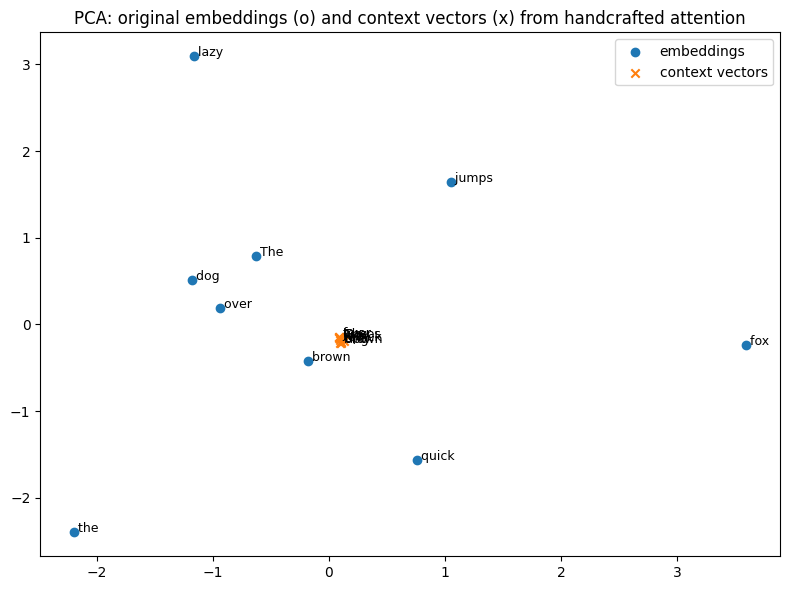

In [3]:
# 3) Visualize token contexts: PCA projection of embeddings and contexts
pca = PCA(n_components=2)
all_vecs = np.vstack([embeddings, context])
proj = pca.fit_transform(all_vecs)
proj_emb = proj[:n_tokens]
proj_ctx = proj[n_tokens:]

plt.figure(figsize=(8,6))
plt.title('PCA: original embeddings (o) and context vectors (x) from handcrafted attention')
plt.scatter(proj_emb[:,0], proj_emb[:,1], marker='o', label='embeddings')
for i,t in enumerate(tokens):
    plt.text(proj_emb[i,0], proj_emb[i,1], f' {t}', fontsize=9)
plt.scatter(proj_ctx[:,0], proj_ctx[:,1], marker='x', label='context vectors')
for i,t in enumerate(tokens):
    plt.text(proj_ctx[i,0], proj_ctx[i,1], f' {t}', fontsize=9)
plt.legend()
plt.tight_layout()
plt.show()


Loading tokenizer and model: bert-base-uncased


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Number of layers: 12


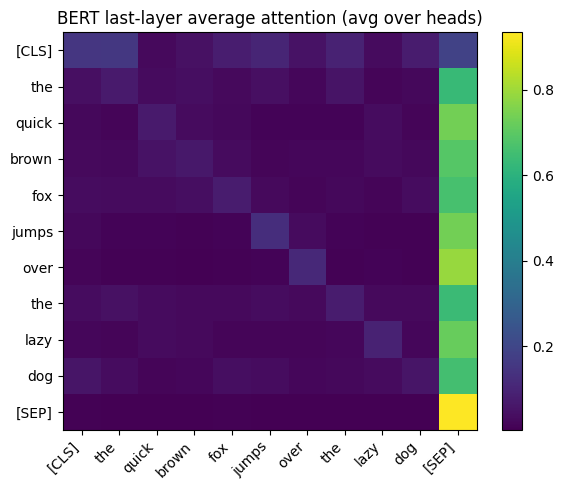

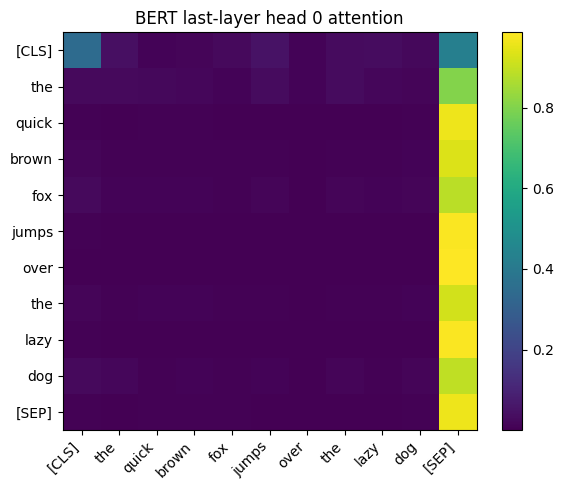

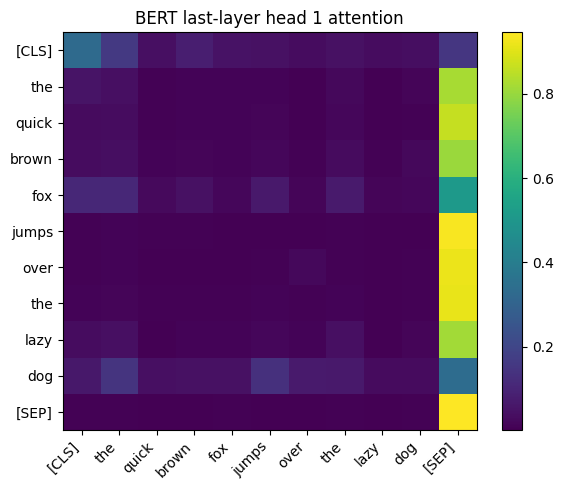

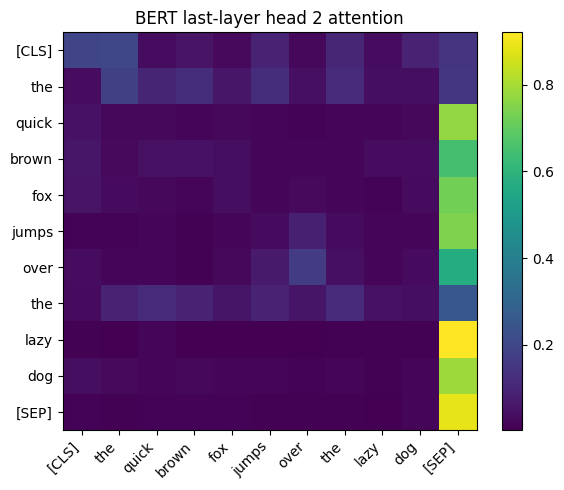

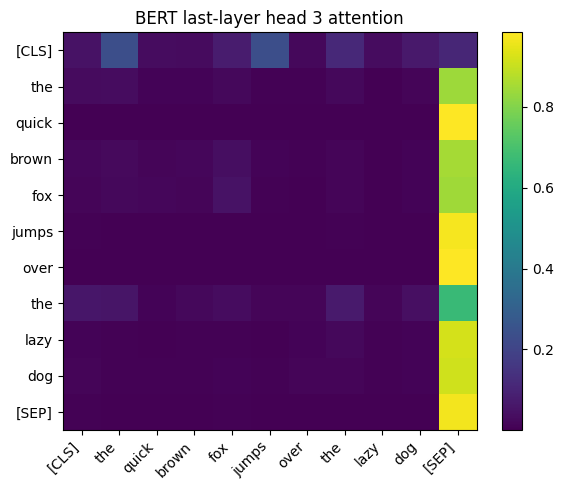

In [4]:
# 4) Optional: extract attention from a HuggingFace transformer (BERT) if available
# This cell attempts to use 'transformers' and 'torch' to get attention matrices from a small pretrained model.
# If transformers is not installed in the environment, the code will print instructions to install it.

try:
    import torch
    from transformers import BertTokenizer, BertModel
    
    model_name = 'bert-base-uncased'
    print('Loading tokenizer and model:', model_name)
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name, output_attentions=True)
    model.eval()

    # Tokenize sentence
    inputs = tokenizer(sentence, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    # outputs.attentions is a tuple: one tensor per layer of shape (batch, num_heads, seq_len, seq_len)
    attentions = outputs.attentions  # tuple of length num_layers
    print('Number of layers:', len(attentions))
    # We'll take the last layer's attentions and average across heads for a simple visualization
    last_layer = attentions[-1][0]  # shape (num_heads, seq_len, seq_len)
    avg_last = last_layer.mean(dim=0).numpy()

    # Map tokenizer tokens back to readable tokens
    token_list = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    plot_attention_matrix(avg_last, token_list, title='BERT last-layer average attention (avg over heads)')

    # Also plot head-wise attention heatmaps for first 4 heads
    num_heads = last_layer.shape[0]
    heads_to_show = min(4, num_heads)
    for h in range(heads_to_show):
        plot_attention_matrix(last_layer[h].numpy(), token_list, title=f'BERT last-layer head {h} attention')

    hf_results = {
        'token_list': token_list,
        'attentions_tuple': attentions,
        'avg_last': avg_last
    }

except Exception as e:
    print('Could not run HuggingFace model in this environment. Error or missing package.')
    print('Error:', e)
    print('\nIf you are running this notebook locally, install dependencies with:\n')
    print('    pip install torch transformers')
    print('\nThen re-run the cell to extract real transformer attentions.')



HuggingFace attentions available? True
BERT tokens: ['[CLS]', 'the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '[SEP]']

Handcrafted tokens: ['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


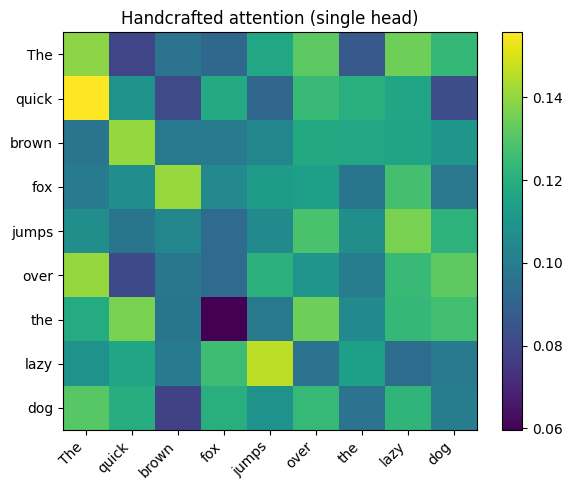

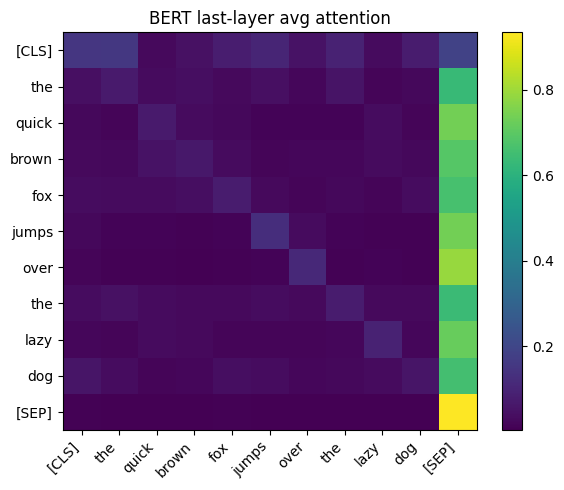

,Setting,AvgAttentionNeighbor,AvgAttentionFar
0,Handcrafted,0.115467,0.112022
1,BERT-last-avg,0.064293,0.094546


In [5]:
# 5) Analysis: Compare handcrafted attention to transformer attention (if available)
# If hf_results is present, compare token-level attention patterns between handcrafted and BERT avg-last-layer
try:
    hf_results
    hf_available = True
except NameError:
    hf_available = False

print('HuggingFace attentions available?', hf_available)

if hf_available:
    # Align token lists: BERT uses special tokens like [CLS], [SEP] and WordPiece tokens; we'll display both matrices side-by-side
    bert_tokens = hf_results['token_list']
    bert_attn = hf_results['avg_last']
    # For comparison, we will upsample or downsample by focusing on the core tokens present in both lists.
    print('BERT tokens:', bert_tokens)
    print('\nHandcrafted tokens:', tokens)
    
    # Simple visual comparison: show both heatmaps
    plot_attention_matrix(attn_weights, tokens, title='Handcrafted attention (single head)')
    plot_attention_matrix(bert_attn, bert_tokens, title='BERT last-layer avg attention')
    
    # Compute a rough summary: average attention weight given to neighboring tokens (distance 1) vs far tokens
    def neighbor_vs_far(attn):
        seq_len = attn.shape[0]
        neigh = []
        far = []
        for i in range(seq_len):
            for j in range(seq_len):
                if i==j: continue
                if abs(i-j)==1:
                    neigh.append(attn[i,j])
                elif abs(i-j)>2:
                    far.append(attn[i,j])
        return np.mean(neigh), np.mean(far)

    hand_neigh, hand_far = neighbor_vs_far(attn_weights)
    bert_neigh, bert_far = neighbor_vs_far(bert_attn)

    df_comp = pd.DataFrame({
        'Setting':['Handcrafted','BERT-last-avg'],
        'AvgAttentionNeighbor':[hand_neigh, bert_neigh],
        'AvgAttentionFar':[hand_far, bert_far]
    })
    display(df_comp)
    
else:
    print('Transformer attentions not available in this environment; only handcrafted attention was computed.')



## Notes and next steps
- The handcrafted attention demonstrates how Q,K,V create an attention matrix that re-weights value vectors to form context vectors.
- Transformer models like BERT have many layers and multiple heads; attention matrices vary across heads and layers and can capture different linguistic phenomena (syntax, coreference, etc.).
- Next steps: visualize attention rollout across layers, inspect specific head behaviors, or build an interactive attention viewer.
